## step02:
## Using the optimal estimated parameters to get the firing-rate for each subject in each trial for each choices

## Then simulate the BOLD signal

### 5 participants

In [79]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd

#from src.attractor_model import *



#import participants' data

subdata = pd.read_csv('data_PL_REWARD_020165_for_rstan.csv')

subdata_1= subdata[(subdata.participant==1)]



In [80]:
#parameters keep same with WANG's MODEL for economic decisions
def F(I, a=175., b=30., d=0.100):
    """F(I) for vector I"""
    
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))


In [81]:

# Let's first define parameters for our model, using dictionaries:

def default_pars():
    '''
    Return: dictionary of default parameters for Wong & Wang (2006) reduced model.
    '''

    z = {}
    ### Stimulus Parameters ###
    z['Jext'] = 5.2e-4 # Stimulus input strength [nA]

    # Working memory (WM) stimulus parameters
    z['mu1'] = 20. # Strength of stimulus 1 [dimensionless]
    z['mu2'] = 0. # Strength of stimulus 2 [dimensionless]

    # Decision making (DM) stimulus parameters
    z['coh'] = 100. # Stimulus coherence [%]
    z['mu0'] = 20. # Stimulus firing rate [spikes/sec]

    ### Network Parameters ###
    z['JE'] = 0.2609 # self-coupling strength [nA]
    z['JI'] = -0.0497 # cross-coupling strength [nA]
    z['I0'] = 0.3255 # background current [nA]
    z['tauS'] = 0.1 # Synaptic time constant [sec]
    z['gamma'] = 0.641 # Saturation factor for gating variable
    z['tau0'] = 0.002 # Noise time constant [sec]
    z['sigma'] = 0.02 # Noise magnitude [nA]
    
    z['n1'] = 6.0          # structural connectivity
    z['n2'] = 12.0       # self-excitation scaling factor
    z['t1'] = 0.9         # long-range scaling factor
    z['t2'] = 0.2     # overall excitatory strength [nA]
    z['a2'] = 0.2       # 0.3255 # background current [nA]
    

    
    return z

def default_expt_pars():
    '''
    Return: dictionary of parameters related to experimental simulation.
    '''

    z = {}
    z['Ntrials'] = 1 # Total number of trials
    z['Ttotal'] = 3.5 # Total duration of simulation [sec]
    z['Tstim'] = 1 # Time of stimulus 1 onset [sec]
    z['Tdur'] = 2. # Duration of stimulus 1 [sec]
    z['dt'] = 0.0005 # Simulation time step [sec]
    z['dt_smooth'] = 0.02 # Temporal window size for smoothing [sec]
    z['S1_init'] = 0.1 # initial condition for dimension-less gating variable S1
    z['S2_init'] = 0.1 # initial condition for dimension-less gating variable S2
    return z


# Now let's make a function that simulates the model in time, for multiple trials:

def run_simBOLD(pars,expt_pars,expt, verbose=False):
    '''
    Run simulation, for multiple trials.

    Parameters:
    pars : circuit model parameters
    expt_pars : other parameters
    expt: Experimental paradigm: 'WM' (for working memory ) or 'DM' (for decision making)

    Return: dictionary with activity traces
    '''

    # Make lists to store firing rate (r) and gating variable (s)
    S1_traj = [];
    S2_traj = [];
    r1_traj = [];
    r2_traj = [];
    r1smooth_traj = [];
    r2smooth_traj = [];
    
    B1_traj = [];
    B2_traj = [];

    
    
    for i in range(expt_pars['Ntrials']): #Loop through trials

        if verbose and (i % 10 == 0):
            print ("trial # ", i+1, 'of', expt_pars['Ntrials'])

        #Set random seed
        np.random.seed(i)

        #Initialize
        r1smooth = []
        r2smooth = []

        NT = int(expt_pars['Ttotal']/expt_pars['dt'])

        Ieta1 = np.zeros(NT+1)
        Ieta2 = np.zeros(NT+1)
        h =  np.zeros(NT+1)
        S1 = np.zeros(NT+1)
        S2 = np.zeros(NT+1)
        r1 = np.zeros(NT)
        r2 = np.zeros(NT)
        B1 = np.zeros(NT+1)
        B2 = np.zeros(NT+1)
        # Initialize S1, S2
        S1[0] = expt_pars['S1_init']
        S2[0] = expt_pars['S2_init']

        for t in range(0,NT): #Loop through time for a trial

            #---- Stimulus------------------------------------------------------

            if expt == 'WM':
                Istim1 = \
                    ((expt_pars['Tstim']/expt_pars['dt'] < t) & \
                     (t<(expt_pars['Tstim']+expt_pars['Tdur'])/expt_pars['dt'])
                    ) * (pars['Jext']*pars['mu1']) # To population 1
                Istim2 = \
                    ((expt_pars['Tstim']/expt_pars['dt'] < t) & \
                     (t<(expt_pars['Tstim']+expt_pars['Tdur'])/expt_pars['dt'])
                    ) * (pars['Jext']*pars['mu2']) # To population 1

            elif expt == 'DM':
                Istim1 = (pars['Jext']*pars['mu0']*(1+pars['coh']/100.)) # To population 1
                Istim2 = (pars['Jext']*pars['mu0']*(1-pars['coh']/100.)) # To population 2

            # Total synaptic input

            Isyn1 = pars['JE']*S1[t] + pars['JI']*S2[t] + Istim1 + Ieta1[t]
            Isyn2 = pars['JI']*S1[t] + pars['JE']*S2[t] + Istim2 + Ieta2[t]
            #Isyn1, Isyn2 = currents_WM(S1[t], S2[t], pars)

            # Transfer function to get firing rate

            r1[t]  = F(Isyn1)
            r2[t]  = F(Isyn2)

            #---- Dynamical equations -------------------------------------------

            # Mean NMDA-mediated synaptic dynamics updating
            S1[t+1] = S1[t] + expt_pars['dt']*(-S1[t]/pars['tauS'] + (1-S1[t])*pars['gamma']*r1[t]);
            S2[t+1] = S2[t] + expt_pars['dt']*(-S2[t]/pars['tauS'] + (1-S2[t])*pars['gamma']*r2[t]);

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta1[t+1] = Ieta1[t] + \
                            (expt_pars['dt']/pars['tau0']) * (pars['I0']-Ieta1[t]) + \
                            np.sqrt(expt_pars['dt']/pars['tau0'])*pars['sigma']*np.random.randn()
            Ieta2[t+1] = Ieta2[t] + \
                            (expt_pars['dt']/pars['tau0'])*(pars['I0']-Ieta2[t]) + \
                            np.sqrt(expt_pars['dt']/pars['tau0'])*pars['sigma']*np.random.randn()
            
            ########################################################
            h[t] = np.max(t**pars['n1']*np.exp(-t/pars['t1']))*t**pars['n1']*np.exp(-t/pars['t1']) - \
                    pars['a2']* np.max(t**pars['n2']*np.exp(-t/pars['t2']))*t**pars['n2']*np.exp(-t/pars['t2'])
            
            
            B1[t] = h[t]*S1[t+1]
            B2[t] = h[t]*S2[t+1]
            ########################################################

        smooth_wind = int(expt_pars['dt_smooth']/expt_pars['dt'])

        r1smooth = np.array([np.mean(r1[j:j+smooth_wind]) for j in range(NT)])
        r2smooth = np.array([np.mean(r2[j:j+smooth_wind]) for j in range(NT)])
        
        
        ## calcualte the h(t)
        
        

        S1_traj.append(S1)
        S2_traj.append(S2)
        r1_traj.append(r1)
        r2_traj.append(r2)
        r1smooth_traj.append(r1smooth)
        r2smooth_traj.append(r2smooth)
        B1_traj.append(B1)
        B2_traj.append(B2)
        #####end####

    tvec = expt_pars['dt']*np.arange(NT)

    z = {'S1':S1_traj, 'S2':S2_traj, # NMDA gating variables
         'r1':r1_traj, 'r2':r2_traj, # Firing rates
         'r1smooth':r1smooth_traj, 'r2smooth':r2smooth_traj, # smoothed firing rates
         't':tvec,
         'B1':B1_traj,
         'B2':B2_traj
        }

    return z

# Now let's build some functions that let us analyze the model using tools of dynamical systems theory: phase plane, nullclines fixed points, and flow fields.


In [113]:
def get_firingrate(params):
    ######
    LR = params[0]

    #let xinyuan try the 1st participants
    

    #create the empty mat with nan to store value
    val = np.full([len(subdata_1),2], np.nan)
    val[0] = 0.5
    
    this_choice_data = np.zeros(len(subdata_1))
    for trial in range(0,len(subdata_1)-1):
        

    
        if subdata_1.accuracy.iloc[trial]==0:
            
            this_choice = subdata_1.inc_option.iloc[trial]
            
            this_choice_data[trial] = this_choice
            
            val[trial+1][this_choice-1]=val[trial][this_choice-1]+LR*(subdata_1.f_inc.iloc[trial]-val[trial][this_choice-1])
            val[trial+1][1-this_choice+1] = 1-val[trial+1][this_choice-1]
        if subdata_1.accuracy.iloc[trial]==1:
            this_choice = subdata_1.cor_option.iloc[trial]
            
            this_choice_data[trial] = this_choice
            
            val[trial+1][this_choice-1]=val[trial][this_choice-1]+LR*(subdata_1.f_cor.iloc[trial]-val[trial][this_choice-1])
            val[trial+1][1-this_choice+1] = 1-val[trial+1][this_choice-1]
    

#getting the value difference
    val_diff = []

    for kk in range(0,len(subdata_1)):
    
        thisval= val[kk][0]-val[kk][1]
   
        val_diff.append(thisval)

    #end loop here
    
    #print(len(val_diff))
    




    for cPrime in range(0,len(val_diff)):#trial by trial
        
        
        


        pars['coh'] = val_diff[cPrime]*100#to make the value not to be too small
        #print('coherence-:',pars['coh'])
        expt_pars['Ntrials'] = 1 # Total number of trials
        pars['JE'] = params[1]
        pars['JI'] = params[2]
        frThreshold = params[3]
        
    
        results = run_simBOLD(pars, expt_pars, expt='DM')
        ##get the firing rate
        firingrate1 = results['r1smooth']#
        firingrate2 = results['r2smooth']#
        

    
        r1_val[cPrime] = results['r1smooth'][0]
        r2_val[cPrime] = results['r2smooth'][0]
        r_avg[cPrime] = (r1_val[0]+r2_val[0])/2

        S1_val[cPrime]= results['S1'][0]
        S2_val[cPrime]= results['S1'][0]
        B1_val[cPrime]= results['B1'][0]
        B2_val[cPrime]= results['B2'][0]
        
        S_avg[cPrime] = (S1_val[0]+S2_val[0])/2
    
    
        for r1smooth, r2smooth in zip(results['r1smooth'], results['r2smooth']): # loop over trials
            rt1 = next((t for t,r1 in zip(results['t'], r1smooth) if r1 > frThreshold), expt_pars['Ttotal'])
            rt2 = next((t for t,r2 in zip(results['t'], r2smooth) if r2 > frThreshold), expt_pars['Ttotal'])
            #print('rt1 is-',rt1)
            #print('rt2 is-',rt2)
            if rt1 < rt2:
                #allchoice.append(1)
                allRT_temp[cPrime]=float(rt1)
                allchoice[cPrime] = 1
              
            if rt2 < rt1:
                
                
                #allchoice.append(2)
                allRT_temp[cPrime]=float(rt2)
                allchoice[cPrime] = 2
               
                
            if rt2==rt1:
                                    
                                    
                allRT_temp[cPrime]=(1+np.random.rand(1)[0])
                allchoice[cPrime] = 0
                

            



    return allRT_temp,S1_val,S2_val,r1_val,r2_val,S_avg,r_avg,allchoice,this_choice_data, B1_val, B2_val


In [84]:
df_allsub_para = pd.read_csv('allsub_para.csv')

thissub_para = np.zeros([4])
thissub_para[0] = df_allsub_para['learning-rate'][0]
thissub_para[1] = df_allsub_para['JE'][0]
thissub_para[2] = df_allsub_para['JI'][0]
thissub_para[3] = df_allsub_para['threshold'][0]

In [85]:
#subdata_1= subdata[(subdata.participant==1)]
rt_data = subdata_1['rt']
#allRT_temp = np.zeros(len(subdata_1))


allRT_temp,S1_val,S2_val,r1_val,r2_val,S_avg,r_avg,subchoice,this_choice_data,B1_val, B2_val = get_firingrate(thissub_para)

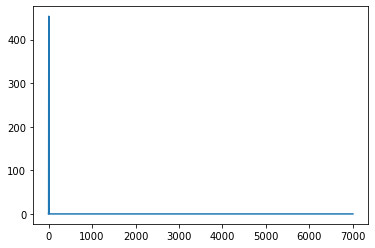

In [86]:
plt.plot(B1_val[0])

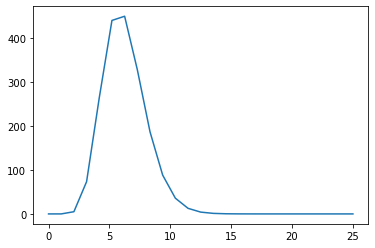

In [87]:
x = np.linspace(0,25,25)
plt.plot(x,B1_val[3][0:25])

In [88]:
np.sum(B1_val[57]-B2_val[57])


-17.665027251798556

In [115]:
for whichsub in range(1,6):
    #load data
    subdata_1= subdata[(subdata.participant==whichsub)]
    
    
    r1_val = np.zeros([len(subdata_1),7000])
    r2_val = np.zeros([len(subdata_1),7000])
    r_avg = np.zeros([len(subdata_1),7000])

    S1_val = np.zeros([len(subdata_1),7001])
    S2_val = np.zeros([len(subdata_1),7001]) 

    B1_val = np.zeros([len(subdata_1),7001])
    B2_val = np.zeros([len(subdata_1),7001])  

    S_avg = np.zeros([len(subdata_1),7001])
    allRT_temp = np.zeros(len(subdata_1))

    allchoice = np.zeros(len(subdata_1))



    pars = default_pars()
    expt_pars = default_expt_pars()
    
    df_allsub_para = pd.read_csv('allsub_para.csv')

    thissub_para = np.zeros([4])
    thissub_para[0] = df_allsub_para['learning-rate'][whichsub-1]
    thissub_para[1] = df_allsub_para['JE'][whichsub-1]
    thissub_para[2] = df_allsub_para['JI'][whichsub-1]
    thissub_para[3] = df_allsub_para['threshold'][whichsub-1]
    
        #subdata_1= subdata[(subdata.participant==1)]
        

    rt_data = subdata_1['rt']
    #allRT_temp = np.zeros(len(subdata_1))
    allRT_temp,S1_val,S2_val,S_avg,r1_val,r2_val,r_avg,subchoice,this_choice_data,B1_val, B2_val = get_firingrate(thissub_para)



   # return allRT_temp,S1_val,S2_val,S_avg,r1_val,r2_val,r_avg,allchoice, B1_val, B2_val



#     #  get default parameters
#     default_BOLDparams=default_BOLDsim_pars(1,)
#     paramsBOLD=default_BOLDparams.copy()
#     #paramsBOLD['G']=1.0

#     # run simulation

    bold1 = np.zeros([len(subdata_1),7000])
    mean_bold1 = np.zeros(len(subdata_1))

    bold2 = np.zeros([len(subdata_1),7000])
    mean_bold2 = np.zeros(len(subdata_1))


    for kk in range(0,len(subdata_1)):


        #print(DATAPACK['B'][kk])
        #bold1[kk]  = 
        mean_bold1[kk]  = np.sum(B1_val[kk])/50


        #print(DATAPACK['B'])
        #DATAPACK['B']



    for kk in range(0,len(subdata_1)):

#         S_input = S2_val[kk]
#         R_input = r2_val[kk]
#         DATAPACK2 = run_simBOLD(paramsBOLD,S_input,R_input)


#         #print(DATAPACK['B'][kk])
#         bold2[kk]  = DATAPACK2['B'][0:7000]
        mean_bold2[kk]  = np.sum(B2_val[kk])/50



    # show the choice-based bold sigmal

#     sub_meanbold = np.zeros(len(subdata_1))

#     for kk in range(0,len(subdata_1)):

#         if subchoice[kk]==1:
#             sub_meanbold[kk] = mean_bold1[kk]

#         if subchoice[kk]==2:
#             sub_meanbold[kk] = mean_bold2[kk]
    
    
    subRT_choice = np.zeros([len(subdata_1),6])
    subRT_choice[:,0] = allRT_temp
    subRT_choice[:,1] = subchoice
    subRT_choice[:,2] = rt_data
    choice_data = this_choice_data
    subRT_choice[:,3] = choice_data
    #subRT_choice[:,4] = sub_meanbold
    subRT_choice[:,4] = mean_bold1
    subRT_choice[:,5] = mean_bold2
    
    
        




    df_sub_meanbold = pd.DataFrame(subRT_choice)
    df_sub_meanbold.columns = ['modeled_RT','modeled_choice','RT','choice','bold1','bold2']  
    #show that
    #df_sub_meanbold

    df_sub_meanbold.to_csv(r'sub_'+str(whichsub)+'_alldata_add_two_meanbold_0806.csv')



In [94]:
np.sum(B1_val[57]-B1_val[17])


-60.207141529229325

In [108]:
np.sum(B2_val[7])/50


37.41928122912353

In [96]:
B1_val[5]

array([0.        , 0.01099898, 5.0224812 , ..., 0.        , 0.        ,
       0.        ])

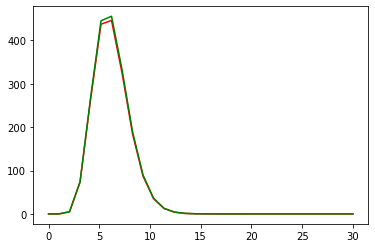

In [98]:
x = np.linspace(0,30,30)
plt.plot(x,B1_val[57][0:30],'red')
plt.plot(x,B1_val[5][0:30],'green')
